# Complete Code Walkthru (contains all iterations 1,2,3 and conclusion)

## Imports

In [79]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, LassoCV
from sklearn.model_selection import train_test_split, cross_val_score
import statsmodels.api as sm
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

pd.options.display.max_rows =4000


## Data Clean

#### Employed a scatterplot, descibe, isnull to clean data
#### Replaced null values with appropriate least case value AND hot encoded that the data was missing vs. not missing

In [80]:
# get the original data post data cleaning in data clean jupyter notebook
df_clean = pd.read_csv('../datasets/cleaned_up_data.csv')

In [81]:
# get the iteration 2 chosen features df
df_iter_2 = pd.read_csv('../datasets/iter_2_df.csv')
df_iter_2 = df_iter_2.drop('Unnamed: 0', axis= 1)

## Iteration 1:  Used hatmap to choose strongly correlated numerical features

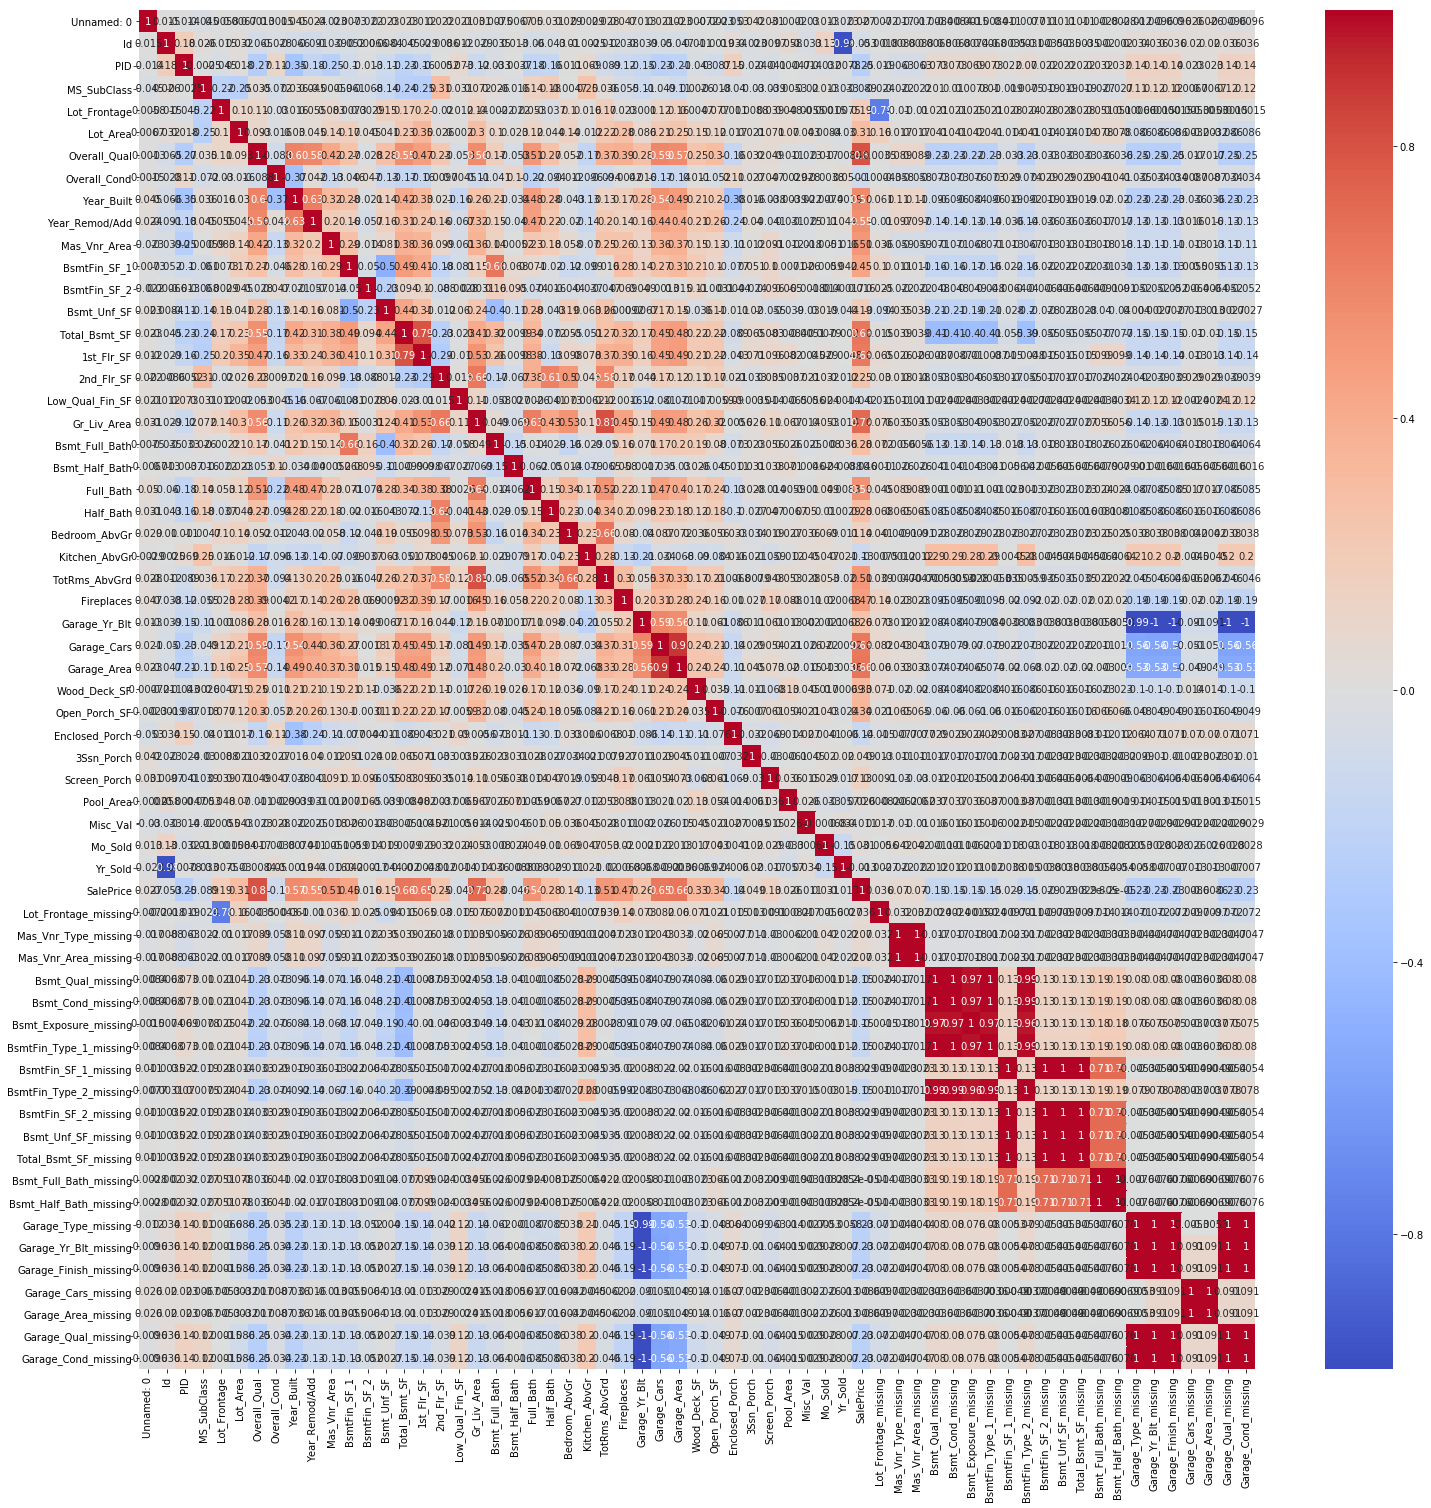

In [82]:
plt.figure(figsize=(25,25))
sns.heatmap(df_clean.corr(), annot= True, cmap='coolwarm')

In [83]:
# Pick for my first features pick those numerical features from the heatmap.  The PARCEL ID might in a round 
#   way indicate what neighborhood it's in.   For the features that came from missing values,  a number of negative
#   correlations came from the no garage and no basement groups,  so i'll just pick one from each.

In [84]:
iter_1_features = ['PID', 'MS_SubClass','Lot_Frontage','Lot_Area','Overall_Qual','Overall_Cond','Year_Built', 
            'Year_Remod/Add','Mas_Vnr_Area','BsmtFin_SF_1','Total_Bsmt_SF','1st_Flr_SF','2nd_Flr_SF', 'Gr_Liv_Area',
            'Bsmt_Full_Bath','Full_Bath', 'Half_Bath','Bedroom_AbvGr','TotRms_AbvGrd', 'Fireplaces','Garage_Yr_Blt',
            'Garage_Cars', 'Garage_Area', 'Wood_Deck_SF', 'Open_Porch_SF','Enclosed_Porch','Bsmt_Qual_missing',
            'Garage_Type_missing']

In [115]:
len(iter_1_features)

28

### Used linear regression on selected features


In [85]:
df = df_clean[iter_1_features]

In [86]:
# do preprocessing 
X = df
y = df_clean['SalePrice']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state= 42)

ss = StandardScaler()
ss.fit(X_train)
X_train_sc = ss.transform(X_train)
X_test_sc = ss.transform(X_test)

In [87]:
# do the modeling
lr = LinearRegression()
lr.fit(X_train_sc, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [88]:
y_train_hat = lr.predict(X_train_sc)

In [89]:
# check the metrics
RMSE = np.sqrt(mean_squared_error(y_train, y_train_hat))
RMSE

27439.29322756046

In [90]:
lr.score(X_train_sc, y_train)

0.8791796475457775

In [91]:
lr.score(X_test_sc, y_test)

0.8675111259264398

In [92]:
cross_val_score(lr, X_train_sc, y_train, cv= 5).mean()

0.8681709546645422

### Used OLS primarily to see that if iteraton 1 was the finish line, then what features to drop


In [93]:
# run OLS primarily as a features filter 
model = sm.OLS(y_train, X_train).fit()


#### Looking at OLS model summary p values, culled the features down to the following

In [94]:
features = ['MS_SubClass','Lot_Frontage','Lot_Area','Overall_Qual','Overall_Cond','Year_Built', 
            'Year_Remod/Add','BsmtFin_SF_1','Total_Bsmt_SF', 'Gr_Liv_Area','Bsmt_Full_Bath',
            'Bedroom_AbvGr','TotRms_AbvGrd', 'Fireplaces','Garage_Area','Enclosed_Porch']

In [118]:
len(features)

16

In [95]:
df = df_clean[features]
X = df
y = df_clean['SalePrice']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state= 42)

ss = StandardScaler()
ss.fit(X_train)
X_train_sc = ss.transform(X_train)
X_test_sc = ss.transform(X_test)

lr = LinearRegression()
lr.fit(X_train_sc, y_train)

lr.score(X_train_sc, y_train)

0.8699657510585614

In [96]:
y_train_hat = lr.predict(X_train_sc)

RMSE = np.sqrt(mean_squared_error(y_train, y_train_hat))
RMSE

28466.34761456197

In [97]:
lr.score(X_test_sc, y_test)

0.8588924891093839

In [98]:
cross_val_score(lr, X_train_sc, y_train, cv=5).mean()

0.8650108351403365

#### the OLS as a filtering device worked well;  r squares remained about the same with 28 to 16 dropping 12



# Iteration 2: dummied up selected categorical features


### - Cosidered neighborhoods THE MOST valuable categorical feature 
### - Deemed building type (single family vs townhouses for example) as important
### - Deemed House Style (1 story vs 2 story vs split level etc) as important
### - Sale Type of financing employed gives info on buyer's financial strength
### - Transformed sale months to selling seasons (theory being spring selling season stronger than others)

In [99]:
df_neighborhood_dummies = pd.get_dummies(df_clean['Neighborhood'], drop_first= True)

df_bldg_type_dummies = pd.get_dummies(df_clean['Bldg_Type'], drop_first= True)

df_house_style_dummies = pd.get_dummies(df_clean['House_Style'], drop_first= True)

def month_to_season_conversion(month):
    if month <= 3:
        return 'spring'
    elif month <= 6:
        return 'summer'
    elif month <= 9:
        return 'fall'
    elif month <= 12:
        return 'winter'
    else:
        print('Houston, we have a problem!')
df_clean['season'] = df_clean['Mo_Sold'].apply(month_to_season_conversion)
df_season_dummies = pd.get_dummies(df_clean['season'], drop_first= True)

df_sale_type_dummies = pd.get_dummies(df_clean['Sale_Type'], drop_first= True)

df_clean = pd.concat([df_clean, df_neighborhood_dummies, df_bldg_type_dummies, df_house_style_dummies, \
               df_season_dummies, df_sale_type_dummies], axis= 1)

### Ran correlation on SalePrice only (heatmap too unwieldy!) to choose the strongly related  features

In [100]:
additional_features_iter_2 = [ 'BrDale', 'BrkSide', 'Edwards', 
                   'IDOTRR', 'MeadowV', 'NAmes', 'NoRidge', 'NridgHt','OldTown', 'Sawyer', 'Somerst',
                   'StoneBr', 'Timber', 'Veenker', '2fmCon', 'Duplex', 'Twnhs', 'TwnhsE', '1.5Unf','2Story',
                   'ConLD','summer','New','WD ']   

In [101]:
iter_2_features = iter_1_features + additional_features_iter_2

In [116]:
len(iter_2_features)

52

### Used linear regression on the updated feature list 


In [102]:
df = df_clean[iter_2_features]

X = df
y = df_clean['SalePrice']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state= 42)

In [103]:
lr = LinearRegression()
lr.fit(X_train, y_train)

lr.score(X_train, y_train)

0.903529635812563

In [104]:
y_train_hat = lr.predict(X_train)

RMSE = np.sqrt(mean_squared_error(y_train, y_train_hat))
RMSE

24518.83497595041

In [105]:
lr.score(X_test, y_test)

0.8841292403236309

In [106]:
cross_val_score(lr, X_train, y_train, cv=5).mean()

0.8857363487412899

### Used OLS primarily to see that if iteraton 2 was the finish line, then what features to drop

In [107]:
model = sm.OLS(y_train, X_train).fit()

#### Looking at OLS model summary p values, culled the features down to the following¶

In [108]:
iter_2_features_OLS = ['MS_SubClass', 'Lot_Frontage', 'Lot_Area', 'Overall_Qual',
                        'Overall_Cond', 'BsmtFin_SF_1', 'Total_Bsmt_SF', 'Bsmt_Full_Bath', 
                        'Bedroom_AbvGr', 'TotRms_AbvGrd', 'Fireplaces', 'Garage_Area', 'PID',
                        'Mas_Vnr_Area', '1st_Flr_SF', '2nd_Flr_SF', 'Full_Bath', 'Half_Bath', 'Kitchen_AbvGr', 
                        'Wood_Deck_SF', 'Screen_Porch', 'Bsmt_Qual_missing', 'BrkSide', 'Edwards', 'IDOTRR', 
                        'NAmes', 'NoRidge', 'NridgHt', 'OldTown', 'Somerst', 'StoneBr', '2fmCon', 'New']

In [117]:
len(iter_2_features_OLS)

33

In [109]:
df = df_clean[iter_2_features_OLS]

In [110]:
X = df
y = df_clean['SalePrice']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state= 42)

In [111]:
lr = LinearRegression()
lr.fit(X_train, y_train)

lr.score(X_train, y_train)

0.8986578387026355

In [112]:
y_train_hat = lr.predict(X_train)

RMSE = np.sqrt(mean_squared_error(y_train, y_train_hat))
RMSE

25130.316175506294

In [113]:
lr.score(X_test, y_test)

0.8798573185558337

In [114]:
cross_val_score(lr, X, y, cv= 5).mean()

0.8889988263874589

#### the OLS as a filtering device again worked well; r squares remained about the same with 19 features being dropped from 52 to 33

# Iteration 3: Feature Engineering on the most important features

### Polynomial Features used to breed the most important Neighborhood feature; also season year

##### Or,  using that the worst house in the best neighborhood beats the best house in the worst neighborhood

In [119]:
X = pd.concat([df_neighborhood_dummies, df_clean['Overall_Qual']], axis= 1)
features = list(X.columns)
poly = PolynomialFeatures(include_bias= False)
X_poly = poly.fit_transform(X)
df_neighborhood_times_overall_quality = pd.DataFrame(X_poly, columns= poly.get_feature_names(features))
df_neighborhood_times_overall_quality.shape



(2047, 434)

##### House size (best rooms above ground) in what neighborhood

In [120]:
X = pd.concat([df_neighborhood_dummies, df_clean['TotRms_AbvGrd']], axis= 1)
features = list(X.columns)
poly = PolynomialFeatures(include_bias= False)
X_poly = poly.fit_transform(X)
df_neighborhood_times_total_rooms_above_ground = pd.DataFrame(X_poly, columns= poly.get_feature_names(features))
df_neighborhood_times_total_rooms_above_ground.shape


(2047, 434)

##### The period of time involved going thru the housing crisis and severe national economic recession, so what year and what season

In [121]:
X = pd.concat([df_season_dummies, df_clean['Yr_Sold']], axis= 1)
features = list(X.columns)
poly = PolynomialFeatures(include_bias= False)
X_poly = poly.fit_transform(X)
df_season_times_year_sold = pd.DataFrame(X_poly, columns= poly.get_feature_names(features))
df_season_times_year_sold.shape


(2047, 14)

##### New house in neighborhoods & assisted-financing buyer in what neighborhood

In [122]:
X = pd.concat([df_neighborhood_dummies, df_sale_type_dummies], axis= 1)
features = list(X.columns)
poly = PolynomialFeatures()
X_poly = poly.fit_transform(X)
df_neighborhood_times_sales_type = pd.DataFrame(X_poly, columns= poly.get_feature_names(features))
df_neighborhood_times_sales_type.shape


(2047, 666)

#### AND DEFINITELY KEEP THE NEIGHBORHOOD SQUARED SINCE NEIGHBORHOOD IS UTMOST IMPORTANCE!!!


In [123]:
df_clean = pd.concat([df_clean, df_neighborhood_times_overall_quality, \
                     df_neighborhood_times_total_rooms_above_ground, \
                      df_season_times_year_sold, df_neighborhood_times_sales_type], axis= 1)

### Again ran correlation on SalePrice only (heatmap too unwieldy!) to choose the strongly related features

In [125]:
df_clean.corr()['SalePrice']

Unnamed: 0                0.027433
Id                       -0.053056
PID                      -0.253634
MS_SubClass              -0.089106
Lot_Frontage              0.186822
Lot_Area                  0.305112
Overall_Qual              0.802675
Overall_Cond             -0.101462
Year_Built                0.571737
Year_Remod/Add            0.550175
Mas_Vnr_Area              0.511303
BsmtFin_SF_1              0.445234
BsmtFin_SF_2              0.015830
Bsmt_Unf_SF               0.190318
Total_Bsmt_SF             0.664222
1st_Flr_SF                0.647931
2nd_Flr_SF                0.247839
Low_Qual_Fin_SF          -0.041925
Gr_Liv_Area               0.718762
Bsmt_Full_Bath            0.283454
Bsmt_Half_Bath           -0.046159
Full_Bath                 0.537521
Half_Bath                 0.282535
Bedroom_AbvGr             0.135393
Kitchen_AbvGr            -0.126179
TotRms_AbvGrd             0.508719
Fireplaces                0.474690
Garage_Yr_Blt             0.259601
Garage_Cars         

In [126]:
additional_features_iter_3 = ['BrDale^2',   'BrDale Overall_Qual',  'BrkSide^2',  'BrkSide Overall_Qual',  
                              'CollgCr Overall_Qual','Edwards^2',   'Edwards Overall_Qual',  'IDOTRR^2',
                              'IDOTRR Overall_Qual',  'MeadowV^2', 'MeadowV Overall_Qual','NAmes^2',
                              'NAmes Overall_Qual',  'NoRidge^2',  'NoRidge Overall_Qual',  'NridgHt^2',
                              'NridgHt Overall_Qual','OldTown^2', 'OldTown Overall_Qual',  'Sawyer^2',
                              'Sawyer Overall_Qual',  'Somerst^2', 'Somerst Overall_Qual',
                              'StoneBr^2',  'StoneBr Overall_Qual',  'Timber^2',   'Timber Overall_Qual',
                              'Overall_Qual^2']

In [127]:
iter_2_features = ['MS_SubClass','Lot_Frontage','Lot_Area','Overall_Qual','Overall_Cond','Year_Built','Mas_Vnr_Area',
                   'BsmtFin_SF_1','Total_Bsmt_SF','2nd_Flr_SF','Bsmt_Full_Bath','Full_Bath','Bedroom_AbvGr',
                   'TotRms_AbvGrd','Fireplaces','Garage_Yr_Blt','Garage_Cars','Garage_Area','Wood_Deck_SF',
                   'Open_Porch_SF','Enclosed_Porch','Bsmt_Qual_missing','Garage_Type_missing','PID','Year_Remod/Add',
                   '1st_Flr_SF','Gr_Liv_Area','Half_Bath', 'Screen_Porch', 'Bsmt_Cond_missing','Garage_Type_missing',
                   'BrDale','BrkSide','ClearCr','CollgCr','Crawfor','Edwards', 'IDOTRR', 'MeadowV', 'NAmes', 'NoRidge',
                   'NridgHt','OldTown','SWISU','Sawyer','Somerst','StoneBr','Timber','Veenker','2fmCon','Duplex',
                   'Twnhs','TwnhsE','1.5Unf','summer','ConLD','New','WD ']

In [128]:
iter_3_features = iter_2_features + additional_features_iter_3
df = df_clean[iter_3_features]
df.shape

(2047, 172)

In [129]:
X = df
y = df_clean['SalePrice']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state= 42)

lr = LinearRegression()
lr.fit(X_train, y_train)

lr.score(X_train, y_train)

0.9256222186297544

In [130]:
y_train_hat = lr.predict(X_train)

RMSE = np.sqrt(mean_squared_error(y_train, y_train_hat))
RMSE

21529.030914782095

In [131]:
lr.score(X_test, y_test)

0.9085856266769528

In [132]:
cross_val_score(lr, X_train, y_train, cv= 5).mean()

0.906894567410949

# Submit this to kaggle
#### LR 3 has a very very small performance edge over iteraton 3 OLS, and Ridge and Lasso below ( based on cross validation scores)
#### The OLS did slightly better than Ridge or Lasso
#### This is a gamble:  taking the slight performance edge overfit LR over the slimmer OLS that may do better on unseen data


In [133]:
# Summission to kaggle

df_kaggle = pd.read_csv('../datasets/test.csv')

In [134]:
def data_clean_kaggle(df):
    # changes due to initial data cleaning
    temp = []
    for col_name in df.columns:
        temp.append(col_name.replace(' ', '_'))
    df.columns = temp

    # changes due to iteration 1  ---------------------------------------------------------------------
    df['Lot_Frontage_missing'] = df['Lot_Frontage'].isnull().apply(lambda x: 1 if x == True else 0)
    df['Lot_Frontage'].fillna(0, inplace= True)
    
    df['Mas_Vnr_Area_missing'] = df['Mas_Vnr_Area'].isnull().apply(lambda x: 1 if x == True else 0)
    df['Mas_Vnr_Area'].fillna(0, inplace= True)
                                                       
    df['BsmtFin_SF_1_missing'] = df['BsmtFin_SF_1'].isnull().apply(lambda x: 1 if x == True else 0)
    df['BsmtFin_SF_1'].fillna(0, inplace= True)
                                                        
    df['Total_Bsmt_SF_missing'] = df['Total_Bsmt_SF'].isnull().apply(lambda x: 1 if x == True else 0)
    df['Total_Bsmt_SF'].fillna(0, inplace= True)
                              
    df['Bsmt_Full_Bath_missing'] = df['Bsmt_Full_Bath'].isnull().apply(lambda x: 1 if x == True else 0)
    df['Bsmt_Full_Bath'].fillna(0, inplace= True)
                              
    df['Garage_Yr_Blt_missing'] = df['Garage_Yr_Blt'].isnull().apply(lambda x: 1 if x == True else 0)
    df['Garage_Yr_Blt'].fillna(0, inplace= True) 
                              
    df['Garage_Cars_missing'] = df['Garage_Cars'].isnull().apply(lambda x: 1 if x == True else 0)
    df['Garage_Cars'].fillna(0, inplace= True) 
                              
    df['Garage_Area_missing'] = df['Garage_Area'].isnull().apply(lambda x: 1 if x == True else 0)
    df['Garage_Area'].fillna(0, inplace= True)
                              
                            
    df['Bsmt_Qual_missing'] = df['Bsmt_Qual'].isnull().apply(lambda x: 1 if x == True else 0)
    df['Bsmt_Qual'].fillna('NA', inplace= True)
    
    df['Garage_Type_missing'] = df['Garage_Type'].isnull().apply(lambda x: 1 if x == True else 0)
    df['Garage_Type'].fillna('NA', inplace= True) 
    
    # changes due to iteration 2  -----------------------------------------------------------------------------
    df_neighborhood_dummies = pd.get_dummies(df['Neighborhood'], drop_first= True)
    df_bldg_type_dummies = pd.get_dummies(df['Bldg_Type'], drop_first= True)
    df_house_style_dummies = pd.get_dummies(df['House_Style'], drop_first= True)
    def month_to_season_conversion(month):
        if month <= 3:
            return 'spring'
        elif month <= 6:
            return 'summer'
        elif month <= 9:
            return 'fall'
        elif month <= 12:
            return 'winter'
        else:
            print('Houston, we have a problem!')
    df['season'] = df['Mo_Sold'].apply(month_to_season_conversion)
    df_season_dummies = pd.get_dummies(df['season'], drop_first= True)
    df_sale_type_dummies = pd.get_dummies(df['Sale_Type'], drop_first= True)
    df['Bsmt_Cond_missing'] = df['Bsmt_Cond'].isnull().apply(lambda x: 1 if x == True else 0)
    df['Bsmt_Cond'].fillna('NA', inplace= True)

    df = pd.concat([df, df_neighborhood_dummies, df_bldg_type_dummies, df_house_style_dummies, \
               df_season_dummies, df_sale_type_dummies], axis= 1)
    
    # changes due to iteration 3  -------------------------------------------------------------------------------
    X = pd.concat([df_neighborhood_dummies, df['Overall_Qual']], axis= 1)
    features = list(X.columns)
    poly = PolynomialFeatures(include_bias= False)
    X_poly = poly.fit_transform(X)
    df_neighborhood_times_overall_quality = pd.DataFrame(X_poly, columns= poly.get_feature_names(features))
    df_neighborhood_times_overall_quality.shape
    
    X = pd.concat([df_neighborhood_dummies, df['TotRms_AbvGrd']], axis= 1)
    features = list(X.columns)
    poly = PolynomialFeatures(include_bias= False)
    X_poly = poly.fit_transform(X)
    df_neighborhood_times_total_rooms_above_ground = pd.DataFrame(X_poly, columns= poly.get_feature_names(features))
    df_neighborhood_times_total_rooms_above_ground.shape

    X = pd.concat([df_season_dummies, df['Yr_Sold']], axis= 1)
    features = list(X.columns)
    poly = PolynomialFeatures(include_bias= False)
    X_poly = poly.fit_transform(X)
    df_season_times_year_sold = pd.DataFrame(X_poly, columns= poly.get_feature_names(features))
    df_season_times_year_sold.shape

    X = pd.concat([df_neighborhood_dummies, df_sale_type_dummies], axis= 1)
    features = list(X.columns)
    poly = PolynomialFeatures()
    X_poly = poly.fit_transform(X)
    df_neighborhood_times_sales_type = pd.DataFrame(X_poly, columns= poly.get_feature_names(features))
    df_neighborhood_times_sales_type.shape
    
    df = pd.concat([df, df_neighborhood_times_overall_quality, \
                     df_neighborhood_times_total_rooms_above_ground, \
                      df_season_times_year_sold, df_neighborhood_times_sales_type], axis= 1)
    
    
    
    return df

In [135]:
df_kaggle = data_clean_kaggle(df_kaggle)

X_kaggle = df_kaggle[iter_3_features]

y_kaggle_hat = lr.predict(X_kaggle)


In [136]:
id_list = list(df_kaggle['Id'])
sale_price_list = y_kaggle_hat
df_submission = pd.DataFrame(list(zip(id_list, sale_price_list)),
                                   columns= ['Id', 'SalePrice'])

df_submission.to_csv('../datasets/iter_3_submission.csv', index= False)

### OLS on iteration 3

In [137]:

model = sm.OLS(y_train, X_train).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:              SalePrice   R-squared (uncentered):                   0.987
Model:                            OLS   Adj. R-squared (uncentered):              0.987
Method:                 Least Squares   F-statistic:                              1612.
Date:                Thu, 03 Oct 2019   Prob (F-statistic):                        0.00
Time:                        14:15:55   Log-Likelihood:                         -17547.
No. Observations:                1535   AIC:                                  3.524e+04
Df Residuals:                    1464   BIC:                                  3.561e+04
Df Model:                          71                                                  
Covariance Type:            nonrobust                                                  
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
MS_SubClass            -37.4431     38.988     -0.960      0.337    -113.921      39.035
Lot_Frontage            42.0618     20.056      2.097      0.036       2.720      81.404
Lot_Area                 0.5068      0.111      4.548      0.000       0.288       0.725
Overall_Qual         -1.247e+04   2275.128     -5.480      0.000   -1.69e+04   -8005.979
Overall_Qual         -1.247e+04   2275.128     -5.481      0.000   -1.69e+04   -8005.982
Overall_Cond          7987.7338    710.323     11.245      0.000    6594.375    9381.093
Year_Built             136.3394     39.071      3.490      0.000      59.698     212.981
Mas_Vnr_Area             7.4437      4.354      1.710      0.088      -1.098      15.985
BsmtFin_SF_1            21.8810      2.045     10.699      0.000      17.869      25.893
Total_Bsmt_SF           24.6973      3.403      7.257      0.000      18.021      31.373
2nd_Flr_SF              28.1207     11.857      2.372      0.018       4.861      51.380
Bsmt_Full_Bath        4160.1711   1551.002      2.682      0.007    1117.748    7202.595
Full_Bath             7406.6494   1832.546      4.042      0.000    3811.954     1.1e+04
Bedroom_AbvGr        -4668.2303   1169.314     -3.992      0.000   -6961.940   -2374.521
TotRms_AbvGrd          598.6162    399.059      1.500      0.134    -184.173    1381.405
TotRms_AbvGrd          598.6159    399.059      1.500      0.134    -184.173    1381.405
Fireplaces            3857.6347   1210.899      3.186      0.001    1482.353    6232.916
Garage_Yr_Blt          -12.9631     11.647     -1.113      0.266     -35.809       9.883
Garage_Cars           2424.0453   2040.965      1.188      0.235   -1579.483    6427.574
Garage_Area             15.2317      7.090      2.148      0.032       1.323      29.140
Wood_Deck_SF            17.6516      5.439      3.245      0.001       6.982      28.321
Open_Porch_SF           17.4297     10.124      1.722      0.085      -2.430      37.289
Enclosed_Porch         -11.6306     11.062     -1.051      0.293     -33.329      10.068
Bsmt_Qual_missing     5893.6981   2743.232      2.148      0.032     512.613    1.13e+04
Garage_Type_missing  -9112.9613   1.13e+04     -0.804      0.422   -3.14e+04    1.31e+04
PID                   7.712e-06    6.2e-06      1.244      0.214   -4.45e-06    1.99e-05
Year_Remod/Add        -116.4696     37.953     -3.069      0.002    -190.918     -42.022
1st_Flr_SF              26.7661     12.182      2.197      0.028       2.869      50.663
Gr_Liv_Area             20.4465     11.919      1.715      0.086      -2.934      43.827
Half_Bath             5200.1441   1795.131      2.897      0.004    1678.840    8721.448
Screen_Porch            47.5813     10.324     

In [138]:
df.shape

(2047, 172)

In [139]:
df = df_clean[['MeadowV^2','MeadowV Overall_Qual','NAmes^2','NAmes Overall_Qual','NridgHt Overall_Qual','Somerst^2',
              'StoneBr^2','StoneBr Overall_Qual','Timber^2','Timber Overall_Qual','Overall_Qual^2','Lot_Frontage',
             'Lot_Area','Overall_Qual','Overall_Cond','Year_Built','Mas_Vnr_Area','BsmtFin_SF_1','Total_Bsmt_SF',
             '2nd_Flr_SF','Bsmt_Full_Bath','Full_Bath','Bedroom_AbvGr','Fireplaces','Garage_Area','Wood_Deck_SF',
             'Open_Porch_SF','Bsmt_Qual_missing','Year_Remod/Add','1st_Flr_SF','Half_Bath', 'Screen_Porch',
             'Bsmt_Cond_missing','Crawfor', 'MeadowV', 'NAmes','SWISU','Somerst','StoneBr','Timber',
             'Duplex','Twnhs','New']]

In [140]:
iter_3_features_ols = list(df.columns)


In [141]:
X = df
y = df_clean['SalePrice']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state= 42)

lr = LinearRegression()
lr.fit(X_train, y_train)

lr.score(X_train, y_train)

0.9205160966858015

In [142]:
y_train_hat = lr.predict(X_train)

RMSE = np.sqrt(mean_squared_error(y_train, y_train_hat))
RMSE

22255.761816418573

In [143]:
lr.score(X_test, y_test)

0.9034626991768177

In [144]:
cross_val_score(lr, X_train, y_train, cv= 42).mean()

0.9068511768177233

### OLS worked well with just a very small R squared diminishment while dropping 96 out of 172 features

# Ridge & RidgeCV employed


In [145]:
# standardize the data

ss = StandardScaler()
ss.fit(X_train)
X_train_ss = ss.transform(X_train)
X_test_ss = ss.transform(X_test)

In [146]:
ridge_model = Ridge(alpha=10)
ridge_model.fit(X_train_ss, y_train)

ridge_model.score(X_train_ss, y_train)

0.9185918447243268

In [147]:
ridge_model.score(X_test_ss, y_test)

0.9021162319227576

In [148]:
ridge_alphas = np.logspace(0, 5, 100)
ridgeCV_model = RidgeCV(alphas= ridge_alphas, scoring= 'r2', cv= 5)
ridgeCV_model.fit(X_train_ss, y_train)
ridgeCV_model.alpha_

1.4174741629268053

In [149]:
ridgeCV_model.score(X_train_ss, y_train)

0.9204359956652534

In [150]:
ridgeCV_model.score(X_test_ss, y_test)

0.9034584503240924

# Lasso employed

In [151]:
lasso_alphas = np.logspace(-5, 0, 100)
lassoCV_model = LassoCV(alphas= lasso_alphas, cv= 5, max_iter= 6000)
lassoCV_model.fit(X_train_ss, y_train)

//anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 67139639309.0, tolerance: 782723099.5086983
  tol, rng, random, positive)
//anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 68611368019.067505, tolerance: 747258963.2017919
  tol, rng, random, positive)
//anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 55946429731.40692, tolerance: 784345114.1260934
  tol, rng, random, positive)
//anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase 

LassoCV(alphas=array([1.00000000e-05, 1.12332403e-05, 1.26185688e-05, 1.41747416e-05,
       1.59228279e-05, 1.78864953e-05, 2.00923300e-05, 2.25701972e-05,
       2.53536449e-05, 2.84803587e-05, 3.19926714e-05, 3.59381366e-05,
       4.03701726e-05, 4.53487851e-05, 5.09413801e-05, 5.72236766e-05,
       6.42807312e-05, 7.22080902e-05, 8.11130831e-05, 9.11162756e-05,
       1.02353102e-04, 1.14975700e-0...
       2.78255940e-01, 3.12571585e-01, 3.51119173e-01, 3.94420606e-01,
       4.43062146e-01, 4.97702356e-01, 5.59081018e-01, 6.28029144e-01,
       7.05480231e-01, 7.92482898e-01, 8.90215085e-01, 1.00000000e+00]),
        copy_X=True, cv=5, eps=0.001, fit_intercept=True, max_iter=6000,
        n_alphas=100, n_jobs=None, normalize=False, positive=False,
        precompute='auto', random_state=None, selection='cyclic', tol=0.0001,
        verbose=False)

In [153]:
lassoCV_model.alpha_

0.8902150854450392

In [154]:
lassoCV_model.score(X_train_ss, y_train)

0.9205160360329089

In [155]:
lassoCV_model.score(X_test_ss, y_test)

0.9034600197529645

# -------------------------------------------------------------------------------------------

# Conclusion:  LR 3, OLS 3, Ridge and Lasso had very close R squares


## OLS and RL did very slightly better than Ridge or Lasso.  

## RL did tiny tiny bit better performance wise than OLS 

## Picked LR over OLS for kaggle because of that, and that there's really only bragging rights involved 

## If I had real money or skin in the game, I'd go with OLS --- best value of performance vs. streamlining 